In [3]:
import pandas as pd
import numpy as np

from IPython.core.display import HTML, display

from bokeh.embed import file_html
from bokeh.models import ColumnDataSource, Patches, HoverTool, TapTool, Plot, Range1d, Slider
from bokeh.palettes import Blues9
from bokeh.plotting import vplot
from bokeh.resources import Resources

from constants import PLOT_FORMATS

### Get the data assembled and colored

The following code to get the data assembled is explained in more detail in the notebook "Example pretty static map with data & hover"


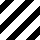
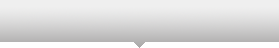
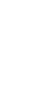
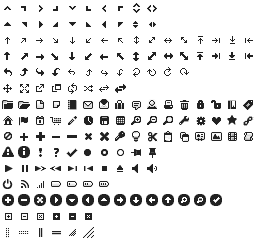
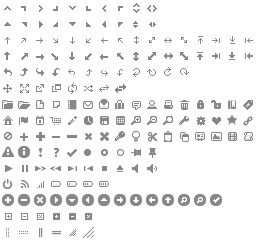
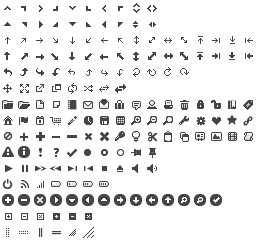
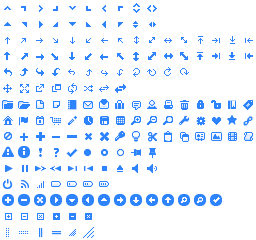
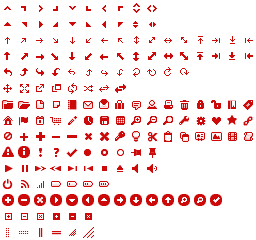
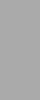
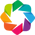
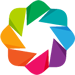
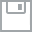
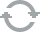
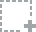
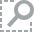
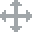
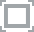
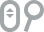

In [5]:
map_data = pd.read_hdf('data/province_map_data.hdf', 'df')
map_data.sort('alpha', inplace=True)
data = pd.read_csv('data/sample_data_by_year.csv')
all_data = map_data.merge(data)

def color_data(data, columns_to_colorify, data_min=None, data_max=None, palette=Blues9):
    # data - the data frame which you are adding colored values to
    # columns_to_colorify - a list of strings which select the columns
    
    if data_min is None:
        num_only = data[columns_to_colorify]
        global_min = num_only.min().min()
        data_min = np.floor(global_min)

    if data_max is None:
        num_only = data[columns_to_colorify]
        global_max = num_only.max().max()
        data_max = np.ceil(global_max)
    
    data_range = data_max - data_min
    bin_factor = data_range / len(palette)
    
    def _get_color(value, palette):
        index = int(value / bin_factor)
        return palette[index - 1]

    for column_name in columns_to_colorify:
        color_name = '%s_color' % column_name
        data[color_name] = data['%s' % column_name].apply(_get_color, args=([palette]))
    return data

colored_data = color_data(all_data, [str(x) for x in range(1990, 2015)])
source = ColumnDataSource(colored_data)

def setup_china_map_plot(start_time, plot_width=600, x_range=[70, 140], y_range=[10, 60], title=""):
    aspect_ratio = (x_range[1] - x_range[0]) / (y_range[1] - y_range[0])
    plot_height = int(plot_width / aspect_ratio)
    x_range = Range1d(x_range[0], x_range[1])
    y_range = Range1d(y_range[0], y_range[1])
    plot = Plot(
        x_range=x_range, 
        y_range=y_range, 
        title=title, 
        plot_width=plot_width, 
        plot_height=plot_height, 
        **PLOT_FORMATS)
    
    countries = Patches(
        xs='xs', 
        ys='ys',
        fill_color='%s_color' % start_time,
        line_color=Blues9[0]
    )    
    
    
    tooltips = "<span class='tooltip-text year'>%s</span>" % start_time                   
    tooltips += "<span class='tooltip-text country'>@name_en</span>"               
    tooltips += "<span class='tooltip-text value'>@%s</span>" % start_time                                    
    plot.add_tools(HoverTool(tooltips=tooltips))
    
    plot.add_glyph(source, countries)
    return plot


PLOT_WIDTH = 900
TITLE = 'Random data'
START_TIME = '1990'

map_box = setup_china_map_plot(START_TIME, plot_width=PLOT_WIDTH, title=TITLE)


#slider = Slider(start=1990, end=2015, value=1, step=1, title="Year")
#layout = vplot(map_box, slider)
resources = Resources(mode='inline', minified=False)


html = file_html(map_box, resources, "")

display(HTML(html))